# Introduction

Asch writes

> The quantitative results are clear and unambiguous.

Our goal for today is to figure out how to interpret this sentence. As we discussed last time, quantitive results do not mean anything in the absence of a model. Most likely, Asch has an implicit, undescribed model in mind when he writes those words. But we can do better, by developing explicit models that allow for more rigorous assessment of the data. This process will also showcase the power of our modeling workflow. In the first unit, we built up the workflow very slowly over many classes. Now we'll get through the whole thing in one lecture. So this class will be intense but the payoff is an illustration of everything we've learned so far. 

The main new topics will be models of heterogeneity. Often times, we think that some experimental intervention should effect different people differently. Maybe our experiment works on some people but not others. In those cases, we say the effectiveness of our intervention is heterogeneous. Our stock binomial distribution fails in these cases. It assumes each person in the experiment has the same underlying accuracy. We'll introduce mixture models as a way of tackling this problem.

# Setting up the problem

All the code in the below section was covered in Lecture 11. Just run these cells so everything is ready to go.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

url = "https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Asch_experiment_1_data"
url = r"C:\Users\dsaun\github_projects\cogs-303\Asch_experiment_1_data" # local path - ignore this

df = pd.read_csv(url)
df

,treatment,mistakes
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
82,0,0
83,0,0
84,0,0
85,0,1


<BarContainer object of 13 artists>

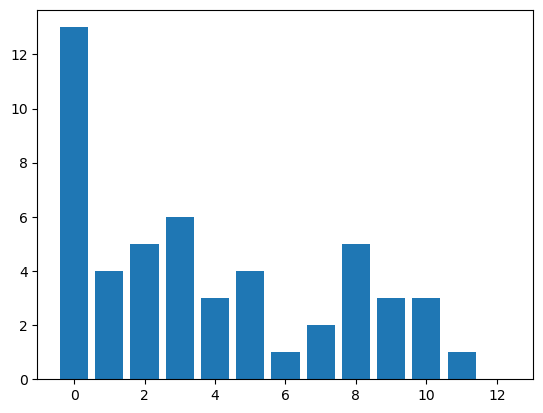

In [2]:
df_treatment = df[df.treatment == 1]
mistakes_treatment = list(df_treatment.mistakes.values)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = mistakes_treatment.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

<BarContainer object of 13 artists>

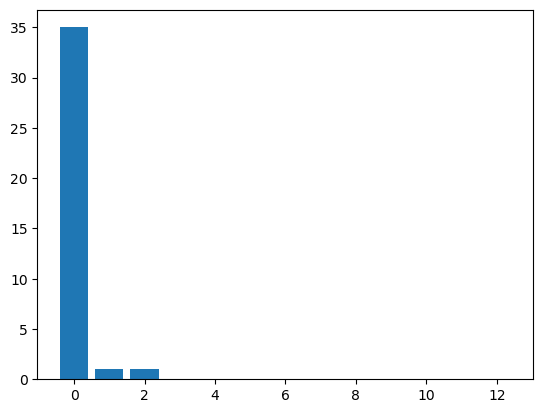

In [3]:
df_control = df[df.treatment == 0]
mistakes_control = list(df_control.mistakes.values)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = mistakes_control.count(i)
    counts.append(matches)

plt.bar(outcomes,counts)

# Doing better than the binomial model

Last class we noted that the application of the binomial distribution to this problem is sustained by two two assumptions:

1. Each person in a group (treatment or control) has the same accuracy level
2. The accuracy levels stay constant over the course of the experiment.

Making these assumptions was mostly just for convenience so we could have a baseline model. We've already thought a lot about how to modify #2 in unit 1. But #1 is a really obviously bad assumption. Asch tells us as much:

> We found evidence of extreme individual differences. There were
in the critical group subjects who remained independent without exception, and there were those who went nearly all the time with the
majority.

What is more, he presents some interview evidence to help us develop a theory about why people conform or remain independent. This sort of *qualitative* data is extremely useful even when we are doing *quantitative* modeling. It guides our selection of models. It is hard to feed qualitative data directly into a likelihood function. But we can draw on qualitative data in other ways. Just like we should incorporate background information into prior distributions, we should incorporate background information into our choice of model, too. 

Let's try to develop a new model. In this model, people will be of two types. The first type are the independents. They rarely conform. The second type are the conformists who usually conform. The model will work in two steps. First, it will randomly decide whether a person is a conformist or an independent. Then it will calculate now many errors that person makes during the experiment. 

The code turns out to be quite tidy:

In [69]:
def simulate_experiment(rate=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=100):
    '''
    rate_of_independents - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent
    conformist_p - the probability of a mistake from a conformist
    n - the number of critical trials in the experiment
    precision - the number of simulated people 
    '''

    data = []

    for i in range(precision):
        
        # decide whether they are independent or conformist
        
        if np.random.choice([1,0],p=[rate, 1-rate]) == 1:
            
            # they are an independent
            # then their errors come from a binomial
            # with a very low error rate
            
            errors = stats.binom(p=independents_p,n=n).rvs()
            
        else:
            
            # they are a conformist
            # then their errors come from a binomial
            # with a high error rate

            errors = stats.binom(p=conformist_p,n=n).rvs()
            
        data.append(errors)

    return np.array(data)

data = simulate_experiment(rate=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=60)
data

array([ 3,  1,  5,  7,  0,  1,  7,  0,  7,  6,  7,  1,  6,  0,  2,  2,  7,
        8,  0,  5,  5,  1,  1,  1,  5,  6,  1,  5,  6,  1,  3,  4,  4,  7,
        0,  0,  6,  3,  5,  0,  7,  0,  1,  0,  4,  8,  1,  0,  5,  1,  0,
        1,  0,  0,  1,  0,  1,  1, 10,  1])

We can simulate to produce hypothetical experiments. This array depicts how many mistakes each of 100 people made. 

Below, I simulate 1000 people and made a plot. This shows the general probability distribution from this sort of model. I want you to take a minute to play with all the parameters. What does it look like each parameter does to the shape of the graph?

<BarContainer object of 13 artists>

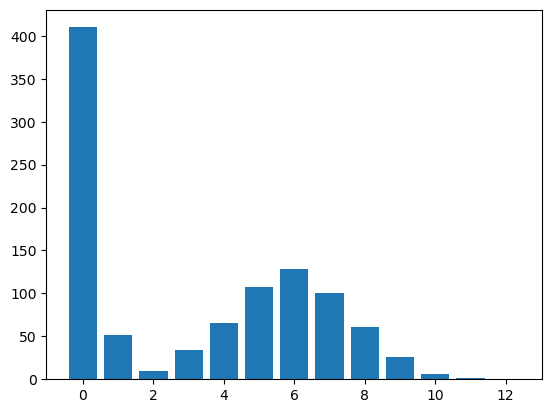

In [81]:
data = simulate_experiment(rate=0.5,independents_p=0.01,conformist_p=0.5,n=12,precision=1000)
data = list(data)

# counting structure

outcomes = range(13)
counts = []
    
for i in outcomes:

    matches = data.count(i)
    counts.append(matches)
    
# plotting structure

plt.bar(outcomes,counts)

The technical name for this distribution is a *mixture*. It's a mixture of two binomial distributions. You define two binomials with the two `p` parameters. Then you specify the rate of mixing with the `rate` parameter. The rate parameter lets us randomly sample between the two binomials and then the binomials work as usual.

# Likelihoods for mixture models

So far we have a data-generating-story, a process model that lets us simulate new data. You'll notice that this produces a much closer match to the observed data than the model we build last lecture. It also makes more sense than the binomial model in terms of the assumptions it makes about the data-generating process. 

To determine how well our model explains the data, we'll need a likelihood. Unfortnately, `scipy.stats` doesn't come with the function we need - instead we'll build up a mixture likelihood out of simpler parts. It will turn out that the likelihood function for a mixture follows the same pattern as the process model we wrote above but in reverse - 

If we feed our ordinary binomial likelihood our dataset, we get an array of likelihoods - one for each person in the experiment. This is a key difference between the lady tasting tea problem and the rest of the course. We'll need a couple of tricks to work with long lists of likelihoods.

In [57]:
stats.binom(n=12,p=0.01).pmf(mistakes_treatment)

array([2.82429536e-01, 2.82429536e-01, 2.82429536e-01, 2.82429536e-01,
       2.82429536e-01, 2.82429536e-01, 2.82429536e-01, 2.82429536e-01,
       2.82429536e-01, 2.82429536e-01, 2.82429536e-01, 2.82429536e-01,
       2.82429536e-01, 3.76572715e-01, 3.76572715e-01, 3.76572715e-01,
       3.76572715e-01, 2.30127770e-01, 2.30127770e-01, 2.30127770e-01,
       2.30127770e-01, 2.30127770e-01, 8.52325076e-02, 8.52325076e-02,
       8.52325076e-02, 8.52325076e-02, 8.52325076e-02, 8.52325076e-02,
       2.13081269e-02, 2.13081269e-02, 2.13081269e-02, 3.78811145e-03,
       3.78811145e-03, 3.78811145e-03, 3.78811145e-03, 4.91051484e-04,
       4.67668080e-05, 4.67668080e-05, 3.24769500e-06, 3.24769500e-06,
       3.24769500e-06, 3.24769500e-06, 3.24769500e-06, 1.60380000e-07,
       1.60380000e-07, 1.60380000e-07, 5.34600000e-09, 5.34600000e-09,
       5.34600000e-09, 1.08000000e-10])

You'll notice that all the numbers are tailed by `e-01` or similar. This means that there are that many decimal places away from zero. So `3.78811145e-03` is equal to `0.00378811145`. This notation will be very common as we start working on more complicated probability problems because the probabiities will quickly get very small.

Now we are also going to have a second binomial distribution with a different value for the accuracy `p`. This represents the conformists group. Let's say this is `0.5`.

In [56]:
stats.binom(n=12,p=0.5).pmf(mistakes_treatment)

array([0.00024414, 0.00024414, 0.00024414, 0.00024414, 0.00024414,
       0.00024414, 0.00024414, 0.00024414, 0.00024414, 0.00024414,
       0.00024414, 0.00024414, 0.00024414, 0.00292969, 0.00292969,
       0.00292969, 0.00292969, 0.01611328, 0.01611328, 0.01611328,
       0.01611328, 0.01611328, 0.05371094, 0.05371094, 0.05371094,
       0.05371094, 0.05371094, 0.05371094, 0.12084961, 0.12084961,
       0.12084961, 0.19335938, 0.19335938, 0.19335938, 0.19335938,
       0.22558594, 0.19335938, 0.19335938, 0.12084961, 0.12084961,
       0.12084961, 0.12084961, 0.12084961, 0.05371094, 0.05371094,
       0.05371094, 0.01611328, 0.01611328, 0.01611328, 0.00292969])

The tricky part is that we just have to combine the two distributions in some principled way. To represent the mixture portion of the model, we can put a weight on each of likelihoods. The weight represents the probability that a given participant comes from a particular distribution. Suppose our weight is $\frac{1}{2}$ - half the participants are conformist and half are independents. Then we should weight the likelihood of each participant by $\frac{1}{2}$. This gives us two new likelihoods.


In [64]:
weight = 0.5
likelihood1 = weight*stats.binom(n=12,p=0.01).pmf(mistakes_treatment)
likelihood2 = (1-weight)*stats.binom(n=12,p=0.5).pmf(mistakes_treatment)

To combine the likelihoods, we *add* them. Why add? Because add represents the logical `or` in probability land. If you roll a six sided die, the probability of a 1 or 2 is $\frac{2}{6}$. We think participants either came from one distribution or the other.

In [65]:
likelihood1 + likelihood2

array([0.14133684, 0.14133684, 0.14133684, 0.14133684, 0.14133684,
       0.14133684, 0.14133684, 0.14133684, 0.14133684, 0.14133684,
       0.14133684, 0.14133684, 0.14133684, 0.1897512 , 0.1897512 ,
       0.1897512 , 0.1897512 , 0.12312053, 0.12312053, 0.12312053,
       0.12312053, 0.12312053, 0.06947172, 0.06947172, 0.06947172,
       0.06947172, 0.06947172, 0.06947172, 0.07107887, 0.07107887,
       0.07107887, 0.09857374, 0.09857374, 0.09857374, 0.09857374,
       0.11303849, 0.09670307, 0.09670307, 0.06042643, 0.06042643,
       0.06042643, 0.06042643, 0.06042643, 0.02685555, 0.02685555,
       0.02685555, 0.00805664, 0.00805664, 0.00805664, 0.00146484])

Finally, we multiply all the likelihoods together to find a single likelihood. Why multiply? Because multiplication corresponds to the logical `and`. If we want to know the probability of getting a `1, 2, 3` in threw rolls of a dice, we take $\frac{1}{6}*\frac{1}{6}*\frac{1}{6}$. We need every roll of the dice to line up just right. `2, 1, 3` is a different outcome so that sequences doesn't count toward the outcome we are after. Similarly, we need to know the likelihood of every participant doing exactly what they did.

In [66]:
np.prod(likelihood1 + likelihood2)

1.5864359985033798e-56

We can wrap all this together into a single function.

In [82]:
def mixture_likelihood(data,rate,independents_p,conformist_p,n):
    '''
    Calculates the likelihood the data, assuming a mixture of two binomial distributions.

    data - an array or list with integer entries.
    rate - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent.
    conformist_p - the probability of a mistake from a conformist.
    n - the number of critical trials in the experiment.
    '''

    ll1 = rate*stats.binom(n=n,p=independents_p).pmf(data)
    ll2 = (1-rate)*stats.binom(n=n,p=conformist_p).pmf(data)

    return np.prod(ll1 + ll2)
    

mixture_likelihood(mistakes_treatment,0.5,0.01,0.5,12)   

3.62202226954534e-60

# Estimating a mixture by hand

With a likelihood in hand, we can turn to the next problem - which combination of parameters fits the data the best? And our bigger goal - what is the posterior distribution over our parameters? How much uncertainty do we have around the parameters of best fit?

This problem presents a novel challenge - we have three parameters. This means the "parameter space" is quite a bit bigger and it will take more effort to search through that space. In unit 1, we had only a single parameter for most of our models. The hot hands model gave a couple more but we didn't try to estimate all the them at once. To get a taste for how challenging this problem can be, try fitting the model by hand. We'll use a simple slider interface to adjust our parameters and draw probability distributions. Try to find the combination of parameters that gives us the best likelihood by adjusting the sliders and clicking "run interact" to recalculate.

In [142]:
import ipywidgets as widgets

def draw_mixture(data,rate,independents_p,conformist_p,n):

    outcomes = range(n+1)

    # build visualization for data

    counts = []
    
    for i in outcomes:

        matches = data.count(i)
        counts.append(matches)

    data_dist = np.array(counts) / sum(counts)
    plt.bar(outcomes,data_dist,alpha=0.5,color="grey",label="data")

    # find likelihood

    likelihood = mixture_likelihood(data,rate,independents_p,conformist_p,n)
    print(likelihood)

    # build visualization for likelihood distribution

    distribution = []

    for i in outcomes:
        ll = mixture_likelihood(i,rate,independents_p,conformist_p,n)
        distribution.append(ll)
    
    plt.bar(outcomes,distribution,color="tab:blue",alpha=0.5,label="model")
    plt.legend()

widgets.interact_manual(draw_mixture,
                 data=widgets.fixed(mistakes_treatment),
                 rate=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 independents_p=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 conformist_p=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 n=widgets.fixed(12));

interactive(children=(FloatSlider(value=0.5, description='rate', max=1.0, step=0.01), FloatSlider(value=0.5, d…

Two things to notice:

- The search is more quite a bit more difficult than it was in unit one. I eventually found `rate = 0.64, independents = 0.11, conformist = 0.59` to be the best I could do. But it took quite a while. One reason it is so much harder is that all the parameters depend on each other. If you set the rate to `0.5`, then different parameters will be best for independents and conformists. You might get stuck optimizing the independents parameter for a long time, only to eventually discover you had the wrong rate parameter. People end up cycling through each parameter several times before settling on some global optima. Other people might never notice they are stuck and end up at a local optima.

- There are actually two distinct combinations of parameters with equally high scores. If you set `rate = 0.46, independents = 0.59, conformist = 0.11`, you'll get nearly the same likelihood as my first guess. This is a problem known as 'non-identifiability'. Whenever two or more combinations of parameters generate the same (or nearly the same) likelihood, then we cannot strictly identify a winner. Non-identifiability can really interfer with algorithms that fit models for a bunch of reasons. If a computer is searching through the parameter space, it might get stuck in a loop as it switches back and forth betweeen two good regions of parameters. It might never settle down into a single point. We'll revisit the topic of non-identifiability several times.

# Bayesian estimation of a mixture model

Our final goal to compute a posterior distribution over all the parameters in the model. We'll start with just trying to estimate a posterior over two parameters and assume that we know the `rate = 0.5``. In a minute we'll see why we don't have the capacity to estimate three parameters until next lecture. Estimating two parameters is already a bit challenging. Unlike in unit 1, we cannot estimate one parameter at a time. We saw above that the likelihood depends on the entire combination of parameters. In turn, we need to find a posterior distribution over combinations of parameters.

One way to think about this is to imagine constructing a posterior table. The rows might represent values the independents. The columns might represent values for the conformists. Our goal is to figure out the posterior value to put in each entry.

| | 0.1 | 0.3 | 0.5 | 
|---|---|---|---|
| 0.1 | ?| ?| ?|
| 0.3 | ?| ?| ?|
| 0.5 | ?| ?| ?|

The posterior will be a product of three things: the likelihood for that combination * the prior for one parameter * the prior for the second parameter.

Let's start coding by specifying a prior distribution over a grid of possible values for independents and conformists. Last time I can you an argument for why we should have rather flat priors on this type of parameter - people's error rate could be as high as 1 if they are influenced by others and as low as 0 if they are not. We'll keep this argument for this model as well.

In [144]:
rate = 0.5
n = 12

independents_grid = np.linspace(0,1,100)
conformist_grid = np.linspace(0,1,100)

ind_prior = stats.beta(1,1).pdf(independents_grid)
ind_prior = ind_prior / sum(ind_prior)

con_prior = stats.beta(1,1).pdf(conformist_grid)
con_prior = con_prior / sum(con_prior)

Calculating the posterior is similar to before - we are going to write a big loop over the values in the grid. However, this time we need to use nested loops. One will loop through an index of rows. The other will loop through an index of columns. Once we have our two coordinates to position ourselves on the table, we'll need extract the relevant parameter value and prior. The rest of the code is just bookkeeping so that we get a nice pretty table at the end.

In [145]:
posterior_table = []

for row in range(100):

    # row is a counter from 0 to 99

    posterior_row = []

    for column in range(100):

        # we use row to index which parameter 
        # we'll need in the likelihood calculation
        # and which prior we'll need for the posterior
        # calculation.

        p1 = independents_grid[row]
        p2 = conformist_grid[column]
        prior1 = ind_prior[row]
        prior2 = con_prior[column]

        likelihood = mixture_likelihood(mistakes_treatment,rate,p1,p2,n)

        posterior = likelihood * prior1 * prior2
        posterior_row.append(posterior)

    posterior_table.append(posterior_row)

# convert to numpy array

posterior_table = np.array(posterior_table)

# normalize the posterior by finding an expectation

posterior_table = posterior_table / np.sum(posterior_table)

# package it into a dataframe to make visualization easier

posterior_distribution = pd.DataFrame(posterior_table,columns=independents_grid,index=conformist_grid)

Visualizing our posterior distribution is also tricky. Now it is a three-dimensional shape. Height represents posterior probability. The x and y dimension represent parameters. Here is one approach:

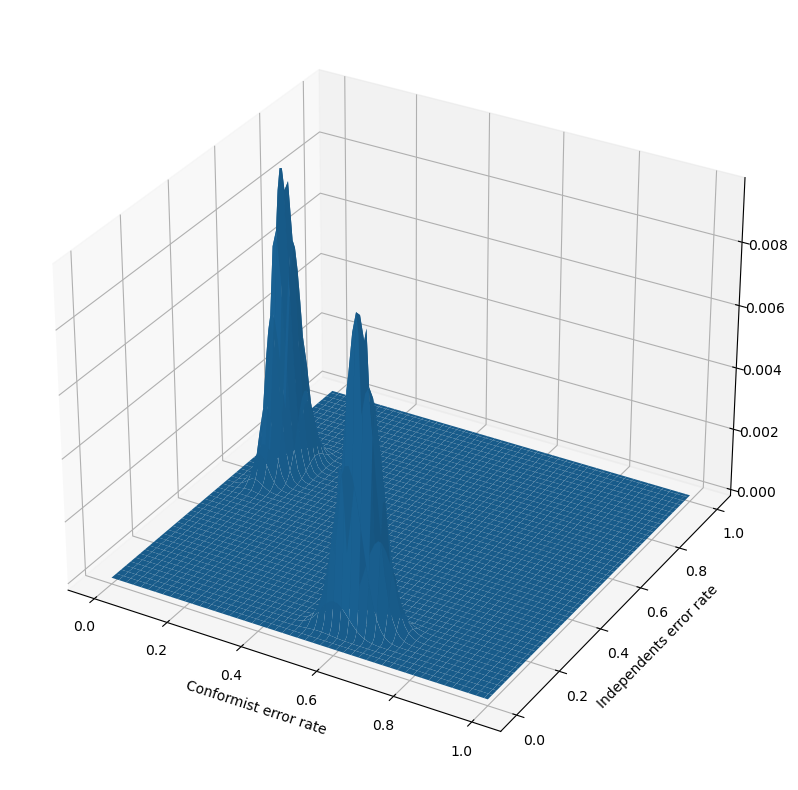

In [146]:
# You don't need to spend time learning this bit of code
# it is unnecessarily complex
# I've put it in the lecture for illustrative purposes

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

x_coord, y_coord = np.meshgrid(independents_grid,conformist_grid)

surf = ax.plot_surface(x_coord, y_coord, posterior_table)
plt.ylabel("Independents error rate")
plt.xlabel("Conformist error rate");

The non-indentifiability problem immediately stands out starkly in this plot! The two mountains represent regions of equally good fit. 

If we focus on just one mountain (the one in the foreground), however, it seems like the conformists have error rates between 0.4 and 0.8 with the most likely possibly being close to 0.6. Meanwhile, the independents make errors with a rate between a bit about 0 and up to 0.2. It looks like the best guess is around 0.1. These numbers are pretty consistent with our slider-based approach earlier.

Alternatively, we can get a bird's eye view using a heatmap of these mountains. The coding is very simple, we import a new package and hand it the dataframe containing the table. Heatmaps typically use a color gradient system where regions of high value will be lightly coloured while regions of low value will be dark.

In [ ]:
import seaborn as sns

sns.heatmap(posterior_distribution,xticklabels=5,yticklabels=10);

# Three, four and more parameters

Why didn't we just find the whole posterior distribution? We assumed, without justification, that the mixture rate was 0.5. We know that changing the mixture rate and also change which error rate parameters fit best. So this three-dimensional posterior still doesn't quite give us the information we need. We truly need a posterior over every combination of all three parameters.

A natural approach would be to just add another loop, building a triple nested loop to search through all three grids. This is a bad idea. For one, it will take a lot of time. Our double loop takes 10 seconds to run. If we want to try 100 different values for the rate parameter, we'll need to repeat the double loop 100 times. So that's 1000 seconds or roughly 15 minutes. We could try to cut that time down by searching smaller grid sizes. The tradeoff is that our approximation of the posterior gets worse. More seriously, the grid approximation really starts to fail once you have four or more parameters. The time it takes to evaluate every combination will inflate rapidly. Meanwhile, if we make the grid more coarse grained, we could start skipping over the important features of the posterior distribution. We might miss a really strong combination all together.

The grid approximation is a great learning tool. It is easy to write code for. It is easy to understand. But no serious modeler can rely on it for any realistic problems. In the next class, we'll abandon it for a state-of-the-art algorithm known as the hamilitonian monte carlo markov chain. It is vastly more complicated. It requires some specialized software. But it can handle models with 3 or 3 million parameters.

# Left over content

----

*Revise*

----

. There are two problems:

1) Estimation. This model has three adjustable parameters, the two `p`s and the rate of mixing. We don't have a technique for estimating three adjustable parameters at once. And it turns out the techniques that do work are quite tricky to implement. I'll link to my [favourite video on monte carlo markov chains](https://www.youtube.com/watch?v=Qqz5AJjyugM) for the keen students who wants to know about where this class could has gone but didn't.

2) Why stop at two groups? Asch gives us some evidence that there might be as many as 6 kinds of people in the experiment. He notes 3 kinds of people who are independent based on interview evidence and 3 kinds of conformists. Should we assume all conformists have the same error rates or three seperate error rates? Frankly, I'm not sure.

There is another, very similar type of model that solves both problems at once. It only has two parameters and represents a broader range of heterogeneity.

In [6]:
def likelihood_mixture(data,rate_of_independents=0.60,independents_p=0.05,conformist_p=0.5,n=12,precision=1000):
    '''
    Calculate the likelihood of the data assuming the mixture model
    Uses a simulation method to estimate the likelihood. Returns both the likelihood
    and the probability distribution over possible outcomes.

    data - list or array containing counts of the errors made by participants
    
    rate_of_independents - what proportion of the subjects should be 
    independents, the rest are conformists.
    independents_p - the probability of a mistake from an independent
    conformist_p - the probability of a mistake from a conformist
    n - the number of critical trials in the experiment
    precision - the number of simulated people 
    '''

    # generate a large number of trials

    trials = simulate_experiment(
        rate_of_independents=rate_of_independents,
        independents_p=independents_p,
        conformist_p=conformist_p,
        n=n,
        precision=precision)
    trials = list(trials)

    # construct a probability 
    # distribution out of those trials

    outcomes = range(n+1)
    counts = []
    
    for i in outcomes:

        matches = trials.count(i)
        counts.append(matches)

    prob_dist = np.array(counts) / sum(counts)

    # match up the observations with the 
    # respective entry in the probability distribution

    likelihoods = []
    for i in data:
        likelihood = prob_dist[i]
        likelihoods.append(likelihood)

    # multiply to find a single likelihood

    likelihood = np.prod(likelihoods)

    return likelihood, prob_dist

We can test out our likelihood function on the real data.

In [7]:
likelihood_mixture(mistakes_treatment,rate_of_independents=0.50,independents_p=0.05,conformist_p=0.6,n=12,precision=2000)

(1.287423488179676e-56,
 array([0.2745, 0.1725, 0.0535, 0.0185, 0.019 , 0.0445, 0.091 , 0.1225,
        0.101 , 0.067 , 0.0305, 0.005 , 0.0005]))

You'll notice that estimated likelihood is somewhat unstable. It switches between `e-56`, `e-57`, and `e-58` even if we keep our parameters the same.. This is not a great sign. It means our approximation approach is very approximate. To put it into perspective, $\frac{1}{100}$ can be written as `1e-2` and $\frac{1}{1000}$ can be written as `1e-3`. If someone told me the likelihood was somewhere between $\frac{1}{10}$ and $\frac{1}{1000}$, I wouldn't be very impressed. But that similar to the level of approximation error in our technique. We'll bracket this problem for a minute.

Our goal is still to figure out which combination of parameters is the best explanation for the data. We can get a sense of that by exploring a range of parameters and seeing how well they match the data, both visually and in terms of likelihood. 

In [15]:
import ipywidgets as widgets

def draw_mixture(data,rate,independent,conformist,precision):

    precision = int(precision)

    outcomes = range(13)
    counts = []
    
    for i in outcomes:

        matches = data.count(i)
        counts.append(matches)
    data_dist = np.array(counts) / sum(counts)

    likelihood, distribution = likelihood_mixture(data,
        rate_of_independents=rate,
        independents_p=independent,
        conformist_p=conformist,
        n=12,
        precision=precision)
    
    print(likelihood)

    plt.bar(outcomes,data_dist,alpha=0.5,color="grey",label="data")
    plt.bar(outcomes,distribution,color="tab:blue",alpha=0.5,label="model")
    plt.legend()

widgets.interact_manual(draw_mixture,
                 data=widgets.fixed(mistakes_treatment),
                 rate=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 independent=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 conformist=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5),
                 precision=widgets.Text('2000'));

C:\Users\dsaun\AppData\Local\Temp\ipykernel_1808\4291833195.py:29: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  widgets.interact_manual(draw_mixture,


interactive(children=(FloatSlider(value=0.5, description='rate', max=1.0, step=0.01), FloatSlider(value=0.5, d…

# Estimating a mixture (pymc)

In [29]:
y_obs = df_treatment.mistakes.values

In [43]:
import pymc as pm
import pytensor.tensor as pt

with pm.Model() as m0:
    w1 = pm.Beta('w1',1,1)
    w = pt.as_tensor([w1,1-w1])
    p0 = pm.Beta('p0',0.5,2) # independent component
    p1 = pm.Beta('p1',2,0.5) # conformist component
    components = [pm.Binomial.dist(n=12,p=p0),pm.Binomial.dist(n=12,p=p1)]
    y = pm.Mixture('error',w=w,comp_dists=components,observed=mistakes_treatment)

pm.draw(y)

array([ 1,  1,  1, 11,  9, 11,  0,  9,  1,  7,  1,  9,  0,  1,  2, 10,  1,
       10,  0, 10,  0,  2,  8,  2, 10,  2,  8, 10, 10, 11,  1,  0, 11,  1,
        0,  1, 12, 11,  0,  9,  0, 10, 10,  1,  0, 11, 10,  9, 11, 10],
      dtype=int64)

In [44]:
pm.draw(w)

array([0.21573291, 0.78426709])

In [ ]:
plt.hist(pm.draw(p1,draws=100))

In [45]:
with m0:
    t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, p0, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
c:\Users\dsaun\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


c:\Users\dsaun\Anaconda3\envs\pymc_env\Lib\site-packages\arviz\utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'p0'}>, <Axes: title={'center': 'p0'}>],
       [<Axes: title={'center': 'p1'}>, <Axes: title={'center': 'p1'}>]],
      dtype=object)

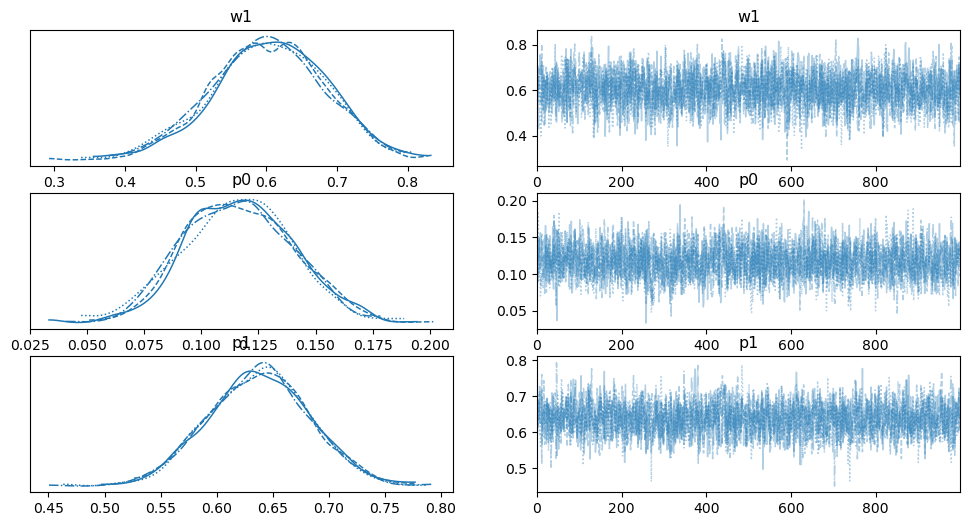

In [46]:
import arviz as az

az.plot_trace(t)

In [10]:
spp = pm.sample_posterior_predictive(t,model=m0)

Sampling: [error]


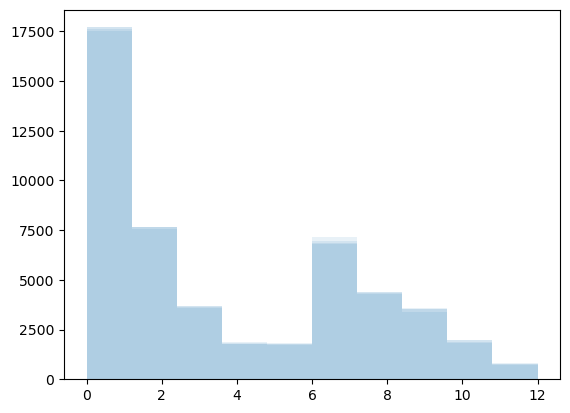

In [12]:
for i in range(4):
    predict = spp.posterior_predictive.error.values[i].flatten()
    plt.hist(predict,alpha=0.1,color="tab:blue")